# A Beginner's Attempt to the Titanic Challenge

This is my first attempt at a Kaggle competion. Also, this is the first time I have a go at trying to make prediction on a dataset without any predefined instructions. I only have a couple of online courses in data science and a few years of python programming as a background. Let's see what comes out. 

Here's what this notebook is **NOT**:
- A top scoring one. My best score is somewhere around 80% (a little below that to be totally honest)

- A tutorial for beginners. This is just how I approach the problem, it's not meant as a guide. Any external feedback on how to improve is much appreaciated

- A scam. I've seen many notebooks scoring one, just feeding the example results back as a submission. You won't see this, or any other kind of trickery in this notebook. 

Well, then let's start, shall we? 

First things first, let's get the imports out of the way

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Plotting stuff
import plotly.express as px 
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

#Machine learning stuff
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


Here's just a function to plot confusion matrices that I had in some old notebook from a course. I'll just keep this here, in case we need it later on. 

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Exploratory Data Analysis

Reading the training dataset. On this, we're gonna do a little EDA to try and see which entries have a predictive value and which ones are useless

In [3]:
train_df=pd.read_csv('/kaggle/input/titanic/train.csv')
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Survival By Age

It looks like the Age of the passengers is not strongly correlated with their survival to the disaster. Except for the infants (age 0-1) which were almost all saved and those older than 65 that were all left to drown. Zoom in on the areas to see. 

In [4]:
px.scatter(train_df, x='PassengerId', y='Age', color='Survived')

Mr. Algernon Henry Wilson looks like an outlier to me. He's the only person his Age that survived. I'll remove it from the test set. 

In [5]:
train_df.iloc[630]

PassengerId                                     631
Survived                                          1
Pclass                                            1
Name           Barkworth, Mr. Algernon Henry Wilson
Sex                                            male
Age                                            80.0
SibSp                                             0
Parch                                             0
Ticket                                        27042
Fare                                           30.0
Cabin                                           A23
Embarked                                          S
Name: 630, dtype: object

In [6]:
train_df.drop([630], inplace=True)

## Survival by Sex

"Women and children first!" 

1921 was probably not a great time to be a woman. On the bright side, you would have had a bigger chance of surviving the Titanic disaster!

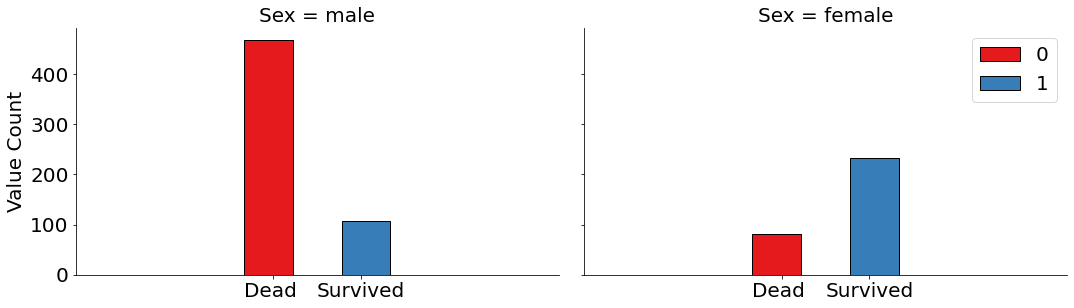

In [7]:
bins = np.linspace(-2, 3, 10)
g = sns.FacetGrid(train_df, col="Sex", hue="Survived", palette="Set1", height=5, aspect=1.5, col_wrap=2)
g.map(plt.hist, 'Survived', bins=bins, ec='k')

g.axes[-1].legend()
g.axes[0].set_ylabel('Value Count')

g.axes[0].set_xlabel('')
g.axes[1].set_xlabel('')

g.axes[0].set_xticks([0, 1])
g.axes[0].set_xticklabels(['Dead ', 'Survived'])

plt.show()

## Survival by Passenger Class

Unsurprisingly, going down from upper to lower class the ratio dead/survived increases. The wealthy first  passengers were saved, while the peasants were left to drown... way to go, Titanic crew!

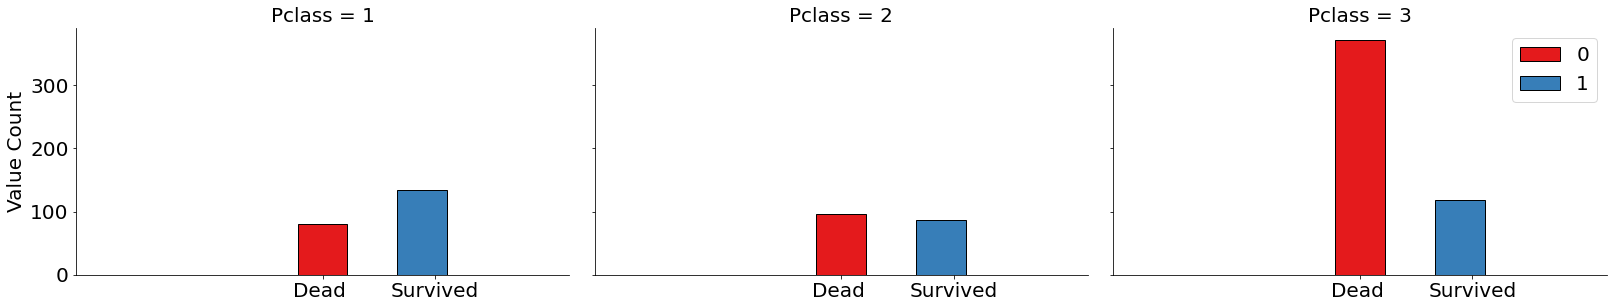

In [8]:
bins = np.linspace(-2, 2, 10)
g = sns.FacetGrid(train_df, col="Pclass", hue="Survived", height=5, aspect=1.5, palette="Set1", col_wrap=3)
g.map(plt.hist, 'Survived', bins=bins, ec='k')
g.axes[0].set_ylabel('Value Count')

for i in range(3):
    g.axes[i].set_xlabel('')

g.axes[0].set_xticks([0, 1])
g.axes[0].set_xticklabels(['Dead ', 'Survived'])
g.axes[-1].legend()
plt.show()

It also looks like there's a correlation between Fare and Survival rate among upper class passengers. There are only three passengers that paid a Fare around 500. I am not sure whether these should be treated as outliers. It does make sense that those who were the whealthiest among the whealthy were saved. It's appalling, but it does make sense. Let's try with and without them.

In [9]:
# Subtracting one to match passenger id with index
train_df.drop([258], inplace=True)
train_df.drop([679], inplace=True)
train_df.drop([737], inplace=True)

It looks like the prediction accuracies don't change with or without those data points. (comment or delete the previous cell to see those points in the graph below)

In [10]:
px.scatter_3d(train_df, x='PassengerId', y='Fare', color='Survived', z='Pclass')

In [11]:
class1_df=train_df.loc[train_df['Pclass'] == 1]
# class1_df
px.scatter(class1_df, x='Fare', y='PassengerId', color='Survived')

# Ticket

Honestly, I am not sure how to treat this data. It looks like it does have some correlation with survival. It is definitely connected with the size of the groups/families that embarked together. It may be used to recover the information about people embarked together that do not count as family members according to Parch and SibSp. But I wouldn't know how to do this. So I'll leave it out for now...

In [12]:
px.scatter(train_df, x='PassengerId', y='Ticket', color='Survived')

In [13]:
ticket_df=train_df.groupby('Ticket').sum()[['Survived']]

In [14]:
px.bar(ticket_df)

## Port

Against my expectations, it looks like the port where the passengers were embarked is correlated with their survival.

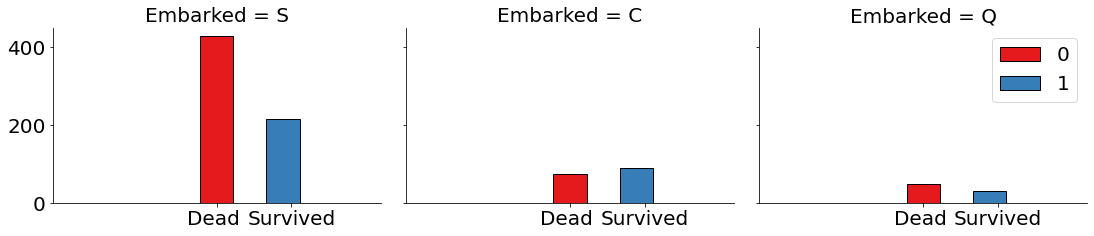

In [15]:
bins = np.linspace(-2, 2, 10)
g = sns.FacetGrid(train_df, col="Embarked", hue="Survived", height=4.0, aspect=1.3, palette="Set1", col_wrap=3)
g.map(plt.hist, 'Survived', bins=bins, ec='k')
for i in range(3):
    g.axes[i].set_xlabel('')

g.axes[0].set_xticks([0, 1])
g.axes[0].set_xticklabels(['Dead ', 'Survived'])
g.axes[-1].legend()
plt.show()

## Family Size

Let's try to see how the size of the groups (families) affected the survival of the passengers.

In [16]:
temp_df=train_df.groupby(['SibSp']).mean()
temp_df

,PassengerId,Survived,Pclass,Age,Parch,Fare
SibSp,,,,,,
0,454.564570,0.341060,2.360927,31.268201,0.185430,23.267824
1,439.727273,0.535885,2.057416,30.089727,0.655502,44.147370
2,412.428571,0.464286,2.357143,22.620000,0.642857,51.753718
3,321.562500,0.250000,2.562500,13.916667,1.312500,68.908862
4,381.611111,0.166667,3.000000,7.055556,1.500000,31.855556
5,336.800000,0.000000,3.000000,10.200000,2.000000,46.900000
8,481.714286,0.000000,3.000000,NaN,2.000000,69.550000


In [17]:
fig=px.bar(temp_df, x=temp_df.index, y='Survived')

fig.show()

In [18]:
temp2_df=train_df.groupby(['Parch']).mean()

In [19]:
px.bar(temp2_df, x=temp2_df.index, y='Survived')

It looks like Parch and SibSp have a similar trend, so let's add them up in a new column, that I will call FamSize, as it represents the family size. Again, it looks like there is an optimum number, then the chance of survival decreases again. However, for some reason adding this data or substituting it to Parch and SibSp does not seem to improve the predictions. 

In [20]:
train_df['FamSize']=train_df['SibSp']+train_df['Parch']
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamSize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [21]:
temp3_df=train_df.groupby(['FamSize']).mean()
px.bar(temp3_df, x=temp3_df.index, y='Survived')

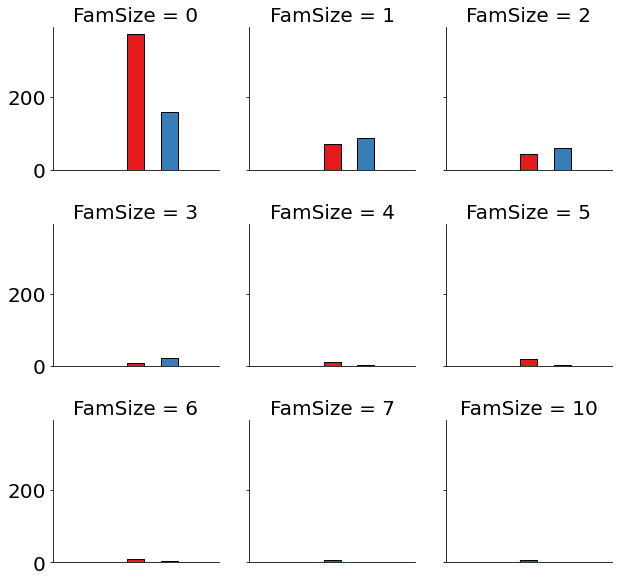

In [22]:
bins = np.linspace(-2, 2, 10)
g = sns.FacetGrid(train_df, col='FamSize', hue="Survived", palette="Set1", col_wrap=3)
g.map(plt.hist, 'Survived', bins=bins, ec='k')
for i in range(9):
    g.axes[i].set_xlabel('')

g.axes[0].set_xticks([])
# g.axes[0].set_xticklabels(['Dead ', 'Survived'])
plt.show()

## Cabin

The Cabin may or may not play a role, but more than half of the values are NaN. I will exclude this column from the data 

In [23]:
train_df['Cabin'].isna().sum()

686

# **Data Preparation**

Redefining index and preparing data for machine learning algorithm. 


In [24]:
train_df.set_index('PassengerId')
# Dropping Cabin
train_df=train_df[['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'FamSize', 'Parch', 'SibSp', 'Ticket', 'Fare', 'Embarked']]


Check for NaN

In [25]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
FamSize          0
Parch            0
SibSp            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

Let's substitute the NaN occurences. The only columns containing NaN are 'Age' and 'Embarked'.

For "Age" we can just compute the mean value and use it in place of NaN. Let's have a quick look at the distribution, just to be sure. It looks a bit skewed, it's not the nice Gaussian distribution I would have expected

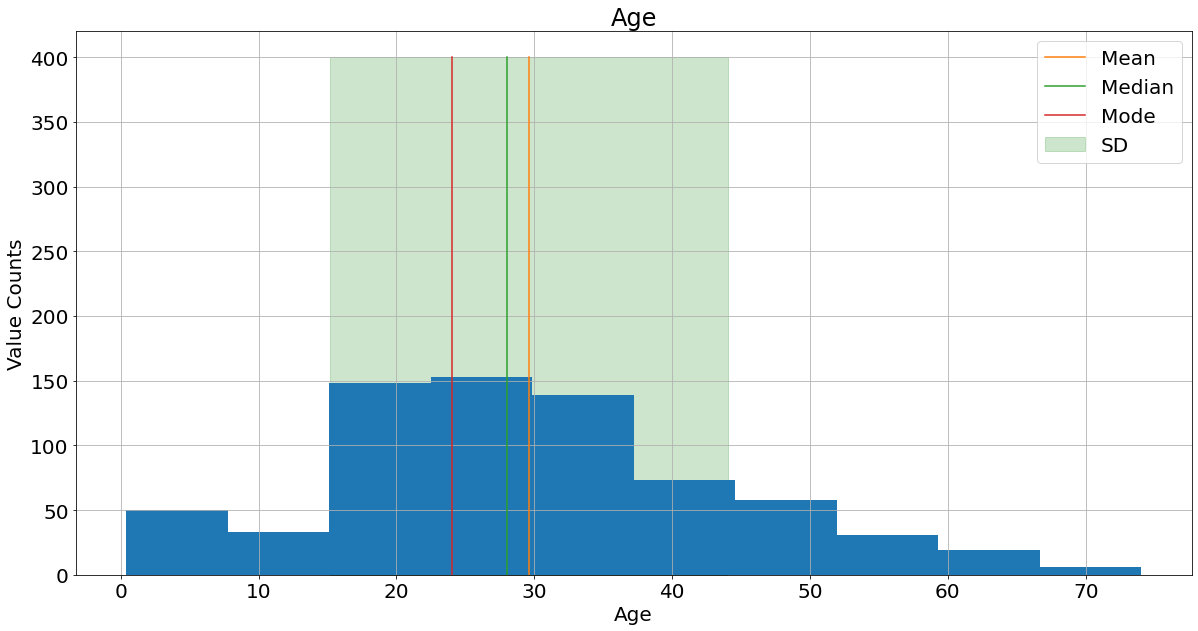

In [26]:
fig, axes = plt.subplots(figsize=(20, 10))
train_df.hist('Age', ax=axes)

std=train_df['Age'].std()

axes.plot([train_df['Age'].mean(),train_df['Age'].mean()], [0, 400], label='Mean')
axes.fill_betweenx([0, 400], [train_df['Age'].mean()-std,train_df['Age'].mean()-std], [train_df['Age'].mean()+std,train_df['Age'].mean()+std], color='g', alpha=0.2, label='SD')

axes.plot([train_df['Age'].median(),train_df['Age'].median()], [0, 400], label='Median')
axes.plot([train_df['Age'].mode(),train_df['Age'].mode()], [0, 400], label='Mode')
# 
axes.set_xlabel('Age')
axes.set_ylabel('Value Counts')

axes.legend()

As the boxplot shows, the distribution is right-skewed, with a few outliers that may affect the mean. Let's try and use the Median instead, to replace NaN values (see below).

<AxesSubplot:xlabel='Age'>

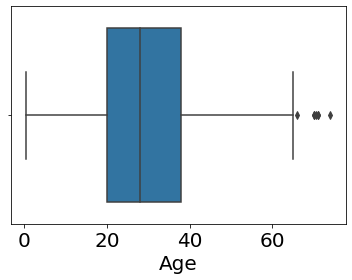

In [27]:
sns.boxplot(x='Age', data=train_df)

The outliers may be trimmed out (see commented code below) but I have tried that and the accuracy of the predictions gets worse. I wish I knew why... 

Anyway, since our goal is a more accurate predicion, I shall keep them. 

In [28]:
# Q1 = train_df['Age'].quantile(0.25)
# Q3 = train_df['Age'].quantile(0.75)
# #Interquartile range
# IQR = Q3 - Q1
# whisker_width = 1.5
# #upper and lower whiskers
# lower_whisker = Q1 -(whisker_width*IQR)
# upper_whisker = Q3 +(whisker_width*IQR)

# #Drop outliers
# train_df.drop(train_df.loc[train_df['Age'] > upper_whisker].index, inplace=True)
# # train_df.drop(train_df.loc[train_df['Age'] < lower_whisker].index, inplace=True)


However, for Emabarked we can't compute the mode of a categorical value. We compute the frequency of each values and substitute the most frequent one, as it's more likely that those passengers embarked from that port. Conceptually is the same thing as using the mode.

In [29]:
train_df['Age'].fillna(float(train_df['Age'].median()), inplace=True)

train_df['Embarked'].value_counts()
train_df['Embarked'].fillna('S', inplace=True)

train_df.isna().sum()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
FamSize        0
Parch          0
SibSp          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Here we need to select the features we will use to train the ML algorithms. I did a bit of testing with different combinations and subsets of columns. So far, I get the best results using the following:

- Pclass
- Sex
- Age
- SibSp
- Parch
- Fare
- Embarked

Male and Female are substituted with 0 and 1. Similarly, One Hot Encoding is used for 'Embarked'

In [30]:
# Dropping a few columns as names and cabin
# Feature=train_df[['Pclass', 'Sex', 'Age', 'FamSize', 'SibSp', 'Parch', 'Fare']]
Feature=train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
# Feature=train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Fare']]

#test: removing Fare and Age
# Feature=train_df[['Pclass', 'Sex', 'SibSp', 'Parch']]

# Replace male and female with 1 and 0, respectively
Feature['Sex'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
# One hot encoding for Embarked
Feature = pd.concat([Feature, pd.get_dummies(train_df['Embarked'])], axis=1)

Feature.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,0
2,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,3,0,35.0,0,0,8.0500,0,0,1


Let's define X and Y

In [31]:
x=Feature
# x[0:5]

Of course our labels will be the Survived column

In [32]:
y=train_df['Survived'].values
y[0:5]



array([0, 1, 1, 1, 0])

Let's standardize the data

In [33]:
x= preprocessing.StandardScaler().fit(x).transform(x)
x[0:5]

array([[ 0.82303564, -0.73844172, -0.56356172,  0.42990395, -0.47367995,
        -0.56665571, -0.47805006, -0.30832082,  0.61253065],
       [-1.57838744,  1.35420302,  0.6743051 ,  0.42990395, -0.47367995,
         0.98844283,  2.09183115, -0.30832082, -1.63257136],
       [ 0.82303564,  1.35420302, -0.25409502, -0.47585568, -0.47367995,
        -0.55026281, -0.47805006, -0.30832082,  0.61253065],
       [-1.57838744,  1.35420302,  0.44220507,  0.42990395, -0.47367995,
         0.54684724, -0.47805006, -0.30832082,  0.61253065],
       [ 0.82303564, -0.73844172,  0.44220507, -0.47585568, -0.47367995,
        -0.54722709, -0.47805006, -0.30832082,  0.61253065]])

And split the data set in a train and test set. 80% - 20% seems like a reasonable choice

In [34]:
#X and y have been defined in the data preparation step above
#Splitting the set in train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# ML model testing

In the following, four different ML models are trained and tested. First, the optimum paramenters are searched through a grid search on a parameter grid, then the models are fitted and tested on the test set. 

## K Nearest Neighbours

First, let's calculate the optimum K value

In [35]:
Kmax=40
#accuracy indicators
mean_acc = np.zeros((Kmax))
std_acc = np.zeros((Kmax))

for k in range(1,Kmax+1):
    #Define the model and fit to train test
    knn=KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train)
    #Predict on the test set
    y_hat=knn.predict(x_test)
    #Verify accuracy against test set labels
    mean_acc[k-1] = metrics.accuracy_score(y_test, y_hat)
    std_acc[k-1] = np.std(y_hat==y_test)/np.sqrt(y_hat.shape[0])

mean_acc

array([0.75280899, 0.75842697, 0.78089888, 0.80337079, 0.82022472,
       0.80337079, 0.7752809 , 0.78089888, 0.76966292, 0.78089888,
       0.79213483, 0.80337079, 0.82022472, 0.81460674, 0.80898876,
       0.81460674, 0.78651685, 0.80898876, 0.79213483, 0.79213483,
       0.78089888, 0.79775281, 0.80337079, 0.79213483, 0.78651685,
       0.79213483, 0.79213483, 0.79775281, 0.79213483, 0.79775281,
       0.79213483, 0.79213483, 0.79775281, 0.79213483, 0.79775281,
       0.73033708, 0.74719101, 0.73595506, 0.73033708, 0.71910112])

Text(0, 0.5, 'Mean Accuracy')

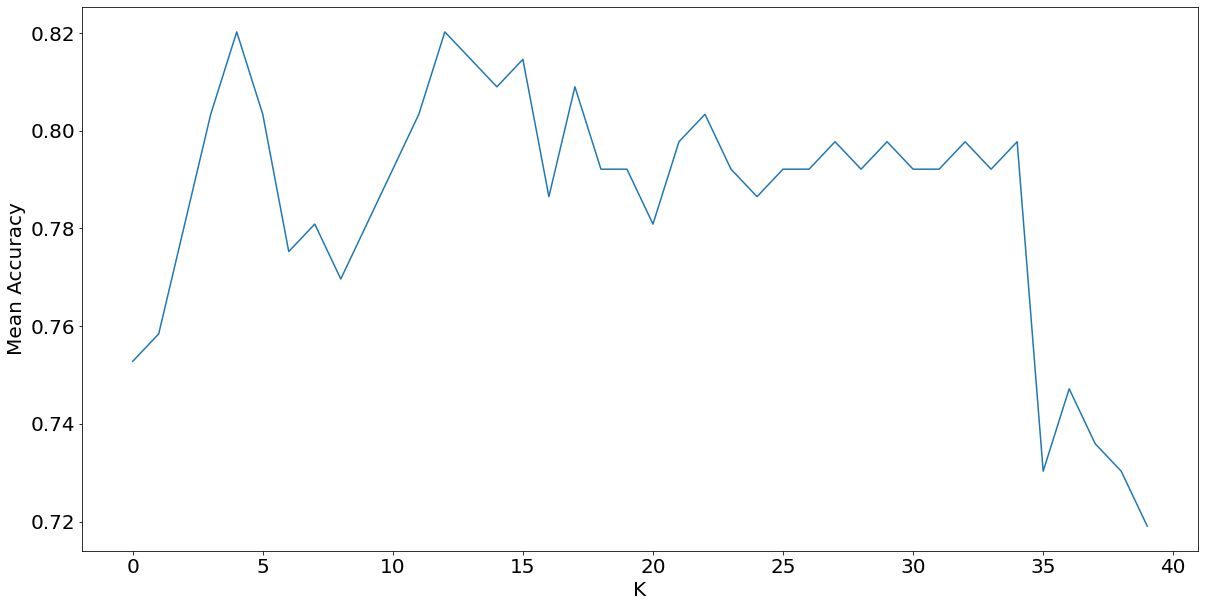

In [36]:
plt.figure(figsize=(20,10))
plt.plot(mean_acc)
plt.xlabel('K')
plt.ylabel('Mean Accuracy')

Let's try optimize the other parameters, scanning a smaller k range

In [37]:
parameters = {'n_neighbors': range(1,15),
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [38]:
knn_cv=GridSearchCV(KNN, parameters, cv=10).fit(x_train, y_train)


In [39]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 14, 'p': 1}
accuracy : 0.8222535211267605


In [40]:
knnScore=knn_cv.score(x_test, y_test)
knnScore

0.8033707865168539

## Decision Tree

Let's now optimize the parameters for a decision Tree

In [41]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [42]:
tree_cv=GridSearchCV(tree, parameters, cv=10).fit(x_train, y_train)


In [43]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.8265191146881288


In [44]:
treeScore=tree_cv.score(x_test, y_test)
treeScore

0.8370786516853933

## Logistic Regression

In [45]:
parameters ={'C':[0.001, 0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [46]:
lr=LogisticRegression()
logreg_cv=GridSearchCV(lr, parameters, cv=10).fit(x_train, y_train)
logreg_cv

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [47]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8067605633802817


In [48]:
logregScore=logreg_cv.score(x_test, y_test)
logregScore

0.8033707865168539

## Support Vector Machine

In [49]:
parameters = {'kernel':['rbf'],
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm_new=svm.SVC()

In [50]:
svm_cv=GridSearchCV(svm_new,parameters, cv=10).fit(x_train, y_train)


In [51]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 31.622776601683793, 'gamma': 0.03162277660168379, 'kernel': 'rbf'}
accuracy : 0.8208651911468813


In [52]:
svmScore=svm_cv.score(x_test, y_test)
svmScore

0.8426966292134831

# Compare the scores of the different optimized models

It looks like SVM is the best performing model

Text(0, 0.5, 'SCORE')

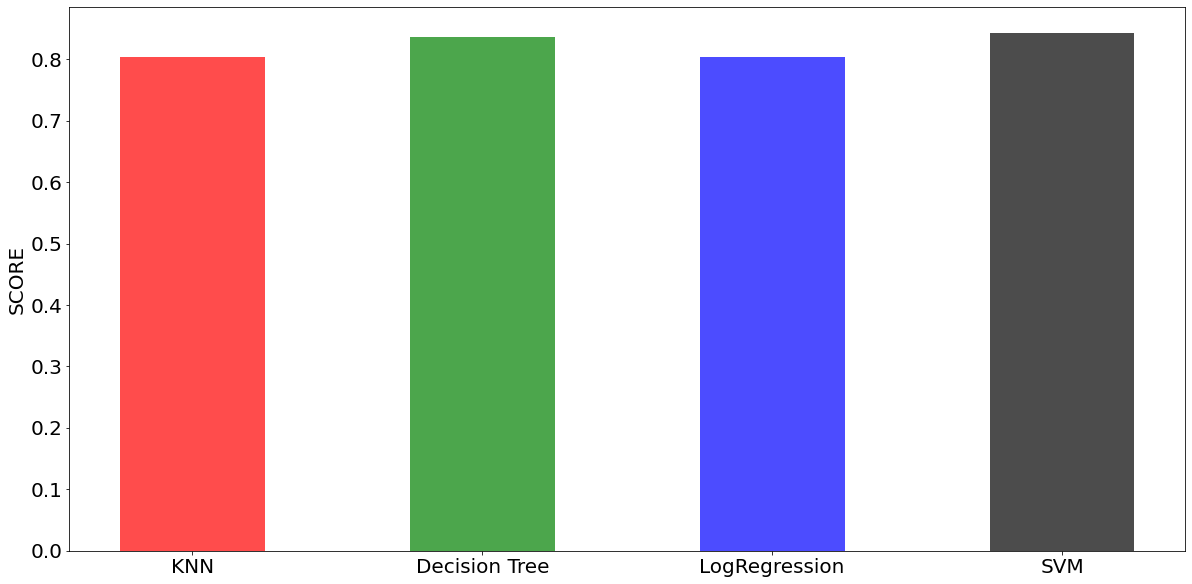

In [53]:
scores=[knnScore, treeScore, logregScore, svmScore]
xax=[0, 1, 2, 3]

fig, axes=plt.subplots(figsize=(20,10))

axes.bar(xax, scores, width=0.5, color=['r', 'g', 'b', 'k'], alpha=0.7)

axes.set_xticks(xax)
axes.set_xticklabels(['KNN', 'Decision Tree', 'LogRegression', 'SVM'])
axes.set_ylabel('SCORE')

If we have a look at the confusion matrix, we notice that the main problem are the false negatives. 

Confusion matrix, without normalization
[[96  4]
 [24 54]]


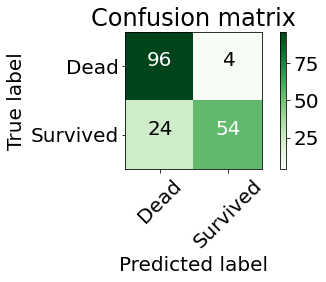

In [54]:
y_hat=svm_cv.predict(x_test)
cnf_matrix = confusion_matrix(y_test, y_hat)
np.set_printoptions(precision=2)

# print(classification_report(y_test,y_hat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Dead','Survived'],normalize= False,  title='Confusion matrix')


We'll refit svn_cv to the whole train test

In [55]:
svm_cv.fit(x,y)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00e-03, 3.16e-02, 1.00e+00, 3.16e+01, 1.00e+03]),
                         'gamma': array([1.00e-03, 3.16e-02, 1.00e+00, 3.16e+01, 1.00e+03]),
                         'kernel': ['rbf']})

# Predictions on the Test Set

Time to compute the predictions on the actual test set, to prepare a submission file. 
First, the test set needs to be imported and undergo the same data preparations steps carried out for the Train test

In [56]:
test_df=pd.read_csv('/kaggle/input/titanic/test.csv')
test_df=test_df[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']]

test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,male,34.5,0,0,330911,7.8292,Q
1,893,3,female,47.0,1,0,363272,7.0000,S
2,894,2,male,62.0,0,0,240276,9.6875,Q
3,895,3,male,27.0,0,0,315154,8.6625,S
4,896,3,female,22.0,1,1,3101298,12.2875,S


A quick look at the age and fare distributions. 'Fare' has quite a few outliers, here we can't just get rid of them, as we will need to submit a prediction for each entry. But since the model is trained on a less skewed distribution, if we use them as they are this will result in a low out of sample accuracy. I'll try to substitute (some of) them with the mean.

<AxesSubplot:>

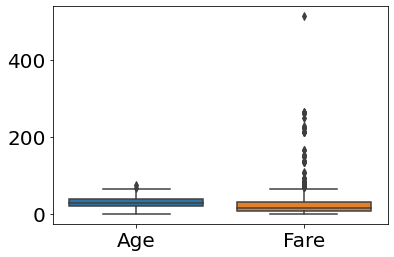

In [57]:
sns.boxplot(data=test_df[['Age','Fare']])

In [58]:
Q1 = test_df['Fare'].quantile(0.25)
Q3 = test_df['Fare'].quantile(0.75)
#Interquartile range
IQR = Q3 - Q1
whisker_width = 1.5
#upper and lower whiskers
lower_whisker = Q1 -(whisker_width*IQR)
upper_whisker = Q3 +(whisker_width*IQR)

#Drop outliers
test_df.loc[test_df['Fare'] > upper_whisker, 'Fare']=float(test_df['Fare'].mean())

# train_df.drop(train_df.loc[train_df['Age'] < lower_whisker].index, inplace=True)


Here's how the distributions look like after treating the outliers

<AxesSubplot:>

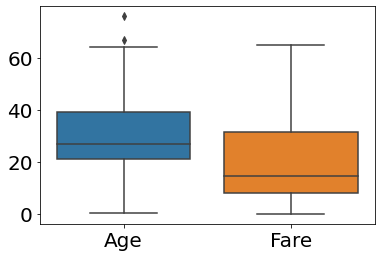

In [59]:
sns.boxplot(data=test_df[['Age','Fare']])

In [60]:
#substitute age outliers
test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)
#substitute Fare and embarked outliers
test_df['Fare'].fillna(float(test_df['Fare'].mean()), inplace=True)
test_df['Embarked'].value_counts()
test_df['Embarked'].fillna('S', inplace=True)

test_df.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Recreate the Family Size columns, just to be consistent. We're not actually using it in the final version

In [61]:
test_df['FamSize']=test_df['SibSp']+test_df['Parch']


Create the feature, as done for the training set.

In [62]:
test_df.set_index('PassengerId')

# test_df.dropna(inplace=True)
# Dropping a few columns as names and cabin
# Feature=test_df[['Pclass', 'Sex', 'Age', 'FamSize', 'SibSp', 'Parch', 'Fare']]
Feature=test_df[['Pclass', 'Sex', 'Age',  'SibSp', 'Parch', 'Fare']]
# Feature=test_df[['Pclass', 'Sex', 'Age',  'SibSp', 'Fare']]

# test, removing age and fare
# Feature=test_df[['Pclass', 'Sex', 'SibSp', 'Parch']]

# Replace male and female with 1 and 0, respectively
Feature['Sex'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
# One hot encoding for Embarked
Feature = pd.concat([Feature, pd.get_dummies(test_df['Embarked'])], axis=1)

# Feature.head()

final_x=Feature
# x[0:5]

final_x= preprocessing.StandardScaler().fit(final_x).transform(final_x)
# x[0:5]

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Let's compute predictions using the best ML method: SVM. The prediction is than converted in a dataframe and written to a 'submission.csv' for submission.

In [63]:
pred_from_svm_cv=svm_cv.predict(final_x)

In [64]:
#KNN
# output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': pred_from_knn_cv})
#Decision Tree
# output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': pred_from_tree_cv})
#Logistic Regression
# output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': pred_from_lr_cv})
#SVM
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': pred_from_svm_cv})


In [65]:
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [66]:
output.to_csv('submission.csv', index=False)

# Conclusions



> 'Pclass', 'Sex', 'Age',  'SibSp', 'Parch', 'Fare' 

Is the best subset I found to predict the survival through a Support Vector Machine model. The correlation between data and survival is quite simple and explains the ratio they used to choose who to save. "Women and childern first!" but also "Rich and wealthy first!"

- The higher Fare and Pclass, the higher the chance of survival

- Women had a higher survival rate than men

- The lower the age, the higher the chance of survival

- The family size has an optimum value around 3

The analysis presented above scores 0.78708. I am sure that there is much to be done to improve it and I am very much open to any comments or suggestions. This one was just my first attempt to apply my moderate knowledge of data science to make predictions. 

Cheers!

